In [1]:
# !pip uninstall --yes fastcore && pip install --upgrade git+git://github.com/fastai/fastcore.git 

In [2]:
# !pip uninstall --yes fastai2 && pip install --upgrade git+git://github.com/fastai/fastai2.git

In [3]:
%load_ext autoreload
%autoreload 2
from fastai2.basics import *
from fastai2.text.all import *
torch.cuda.set_device(0)

In [4]:
bs = 40
wd = 1e-1
moms = (0.95, 0.85, 0.95)#(0.8,0.7,0.8)#
seq_len = 72

In [5]:
lang = 'he'
data_path = Config.config_path/'data'
name = f'{lang}wiki'
tok = 'SP_data_fwd'
text_path = data_path/name
path = Path(f'{data_path}/{name}_{tok}')
data_format = 'token' #morph or token
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt_{tok}', f'{lang}_wt_vocab_{tok}']

In [6]:
class LabelSmoothingCrossEntropyFlat(BaseLoss):
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): 
        super().__init__(LabelSmoothingCrossEntropy, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [7]:
counter = pickle.load(open(str(path/'counter.pkl'), 'rb'))
vocab = make_vocab(counter)
len(vocab)

7984

In [8]:
train_df = pd.read_csv(f'../{data_format}_train.tsv', sep='\t', header=None, names=['comment', 'label'])
train_df['is_valid'] = False
test_df = pd.read_csv(f'../{data_format}_test.tsv', sep='\t', header=None, names=['comment', 'label'])
test_df['is_valid'] = True
df = pd.concat([train_df,test_df], sort=False).rename(columns={'comment': 'text'})
train_df = df[df.is_valid == False]
test_df = df[df.is_valid == True]
len(train_df), len(test_df)

(10244, 2560)

In [9]:
# splits = ColSplitter()(df)
# x_tfms = [attrgetter('text'),
#         Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
#         Numericalize(vocab)]
# dsrc = Datasets(df, tfms=[x_tfms, [attrgetter('label'), Categorize()]], splits=splits, dl_type=SortedDL)
# cls_data = dsrc.dataloaders(bs=bs, before_batch=pad_input_chunk, seq_len=seq_len,
#                            cache=2048, num_workers=8, pin_memory=True)

In [10]:
splits = ColSplitter()(df)#RandomSplitter(0.1, seed=42)(train_df)
x_tfms = [attrgetter('text'),
        Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
        Numericalize(vocab)]
dsrc = Datasets(df,#train_df,
                tfms=[x_tfms, [attrgetter('label'), Categorize()]], splits=splits, dl_type=SortedDL)
cls_data = dsrc.dataloaders(bs=bs, before_batch=pad_input_chunk, seq_len=seq_len,
                           cache=2048, num_workers=8, pin_memory=True)

In [11]:
drop = 0.2
pretrained = False
loss_func = LabelSmoothingCrossEntropyFlat()#CrossEntropyLossFlat()#
learn_c = text_classifier_learner(cls_data, AWD_QRNN, 
                                  metrics=[accuracy, F1Score(average='macro'), MatthewsCorrCoefMulti(None,  None)],
                                  path=path,
                                  loss_func=loss_func,
                                  drop_mult=drop, pretrained=pretrained, wd=wd)
learn_c = learn_c.load_encoder(f'{lang}fine_tuned_enc_{tok}_{data_format}_duplicate')

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.25118863582611084)

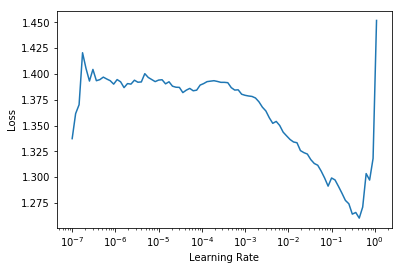

In [12]:
learn_c.lr_find()

In [13]:
lr = 5e-2
# lr *= bs/48  # Scale learning rate by batch size
n_epochs = 15
div = 10

In [14]:
learn_c.fit_one_cycle(n_epochs, lr, wd=wd, moms=moms, div=div)
learn_c.unfreeze()
lr /= 5
learn_c.fit_one_cycle(2*n_epochs, slice(lr/(2.6**4),lr), wd=wd, moms=moms, div=div)

epoch,train_loss,valid_loss,accuracy,f1_score,matthews_corrcoef,time
0,0.899358,0.633562,0.808594,0.563096,0.602032,00:08
1,0.924695,0.604512,0.819531,0.565708,0.590192,00:08
2,0.949294,0.643753,0.823828,0.542124,0.619193,00:08
3,0.956533,0.720702,0.782812,0.542883,0.541074,00:08
4,0.941090,0.716796,0.816016,0.544119,0.600419,00:08
5,0.970859,0.620630,0.821875,0.533875,0.596460,00:09
6,0.945251,0.694599,0.753516,0.439107,0.427130,00:08
7,0.926494,0.589162,0.822266,0.542724,0.598367,00:07
8,0.910792,19.014618,0.754687,0.510785,0.428604,00:08
9,0.936782,1.072347,0.801953,0.550802,0.569818,00:07


/home/oren/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/oren/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


epoch,train_loss,valid_loss,accuracy,f1_score,matthews_corrcoef,time
0,0.643717,0.671954,0.864844,0.666193,0.699585,00:18
1,0.579171,0.894259,0.859375,0.703711,0.686537,00:20
2,0.508376,0.510168,0.887109,0.744954,0.753004,00:19
3,0.538229,0.553264,0.887891,0.741518,0.751908,00:20
4,0.482645,0.510637,0.894141,0.778316,0.768534,00:19
5,0.496534,0.526749,0.892969,0.741207,0.765503,00:18
6,0.442579,0.524304,0.898828,0.731045,0.785677,00:21
7,0.442418,0.525082,0.894141,0.747002,0.776396,00:18
8,0.433134,0.618029,0.864844,0.743519,0.705610,00:20
9,0.409304,0.499166,0.910937,0.786285,0.804969,00:20


In [15]:
test_splits = RandomSplitter(0.0)(test_df)
x_tfms = [attrgetter('text'),
        Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
        Numericalize(vocab)]
test_dsrc = Datasets(test_df, tfms=[x_tfms, [attrgetter('label'), Categorize()]], splits=test_splits, dl_type=SortedDL)
test_data = test_dsrc.dataloaders(bs=bs, before_batch=pad_input_chunk, seq_len=seq_len,
                                  cache=2048, num_workers=8, pin_memory=True)
learn_c.validate(dl=test_data[0])

(#4) [0.4427708089351654,0.935546875,0.8410676293968709,0.8609774850386891]

In [23]:
#[0.4427708089351654,0.935546875,0.8410676293968709,0.8609774850386891]
# learn_c.save(f'{lang}clas_{tok}_{data_format}_fwd_duplicate')

In [17]:
from fastai2.interpret import *
interp = ClassificationInterpretation.from_learner(learn_c)
interp.plot_top_losses(10)

,input,target,predicted,probability,loss
0,"▁xxbos ▁הדבר ▁הנכון ▁ קרה ▁, ▁נ קבע ▁ונ עשה ▁. ▁נבחרת ▁כי ▁היית ▁המתאים ▁ביותר ▁. ▁אינ ך ▁חייב ▁דבר ▁לאיש ▁, ▁בטח ▁לא ▁לאנשי ▁המשטר ▁. ▁תר ים ▁את ▁ה כ פ פה ▁. ▁ארץ ▁ישראל ▁השלמה ▁פחות ▁חשוב ה ▁מחבר ה ▁בריא ה ▁, ▁ נט ול ת ▁ שחיתות ▁, ▁צודק ת ▁ומת ג מל ת ▁את ▁אוהב יה ▁. ▁המדינה ▁אינ ה ▁חול ה ▁. ▁ פרנס יה ▁ רו ו י ▁ שחיתות ▁ו חמס ▁. ▁אם ▁לא ▁למענ נו ▁, ▁למע ן ▁ילדי נו ▁ו יום ▁אחד ▁נכד ינו ▁. ▁ככה ▁אי ▁אפשר ▁להמשיך ▁. ▁בהצלחה ▁, ▁יא ר ▁פניו ▁אליך ▁וי חו ני ך ▁את ▁השאר ▁ תעשה ▁לבד ▁.",1,0,0.9853187799453735,7.177054405212402
1,▁xxbos ▁אבי עד xxunk ▁על ▁הבו טות ▁!,0,2,0.9939829707145691,6.8990702629089355
2,▁xxbos ▁שבת ▁שלום ▁לכולם ▁מעמ ות ת ▁תנו ▁ לחירש ▁ נכים ▁למע ן ▁ נכים ▁וארגו ן ▁ ארצנו ▁החברתי ת,0,2,0.9922254085540771,5.375344753265381
3,"▁xxbos ▁אוהבים ▁ פוליטיקה ▁?? ▁ה ד ף ▁״ ▁ציו צים ▁של ▁ פוליטיקאים ▁״ ▁מי ו עד ▁בדיוק ▁בשביל כם ▁! ▁כנסו ▁עכשיו ▁לק יש ור ▁ו תקבל ו ▁את ▁כל ▁ה צי ו צים ▁המ ענייני ם ▁של ▁כל ▁ה פוליטיקאים ▁בישראל ▁, ▁והכל ▁בד ף ▁אחד ▁! ▁״ ▁ציו צים ▁של ▁ פוליטיקאים ▁״ ▁ ; ▁http s : ▁/ ▁/ ▁m . fa ce book . com ▁/ ▁ p o l it ic s israel s",0,2,0.994429886341095,5.222125053405762
4,"▁xxbos ▁אכן ▁ל יבנו ▁דואב ▁ומצ טר פים ▁אנו ▁ל תפילות ▁ול ת קו ות ▁לראות ▁את ▁הבנים ▁במהרה ▁בריא ים ▁ושלמים ▁. ▁חוב ה ▁עלינו ▁לדא וג ▁ש ארגוני ▁טרור ▁ו חשבו ▁טוב ▁טוב ▁לפני ▁ב צו ע ▁מעשי ▁טרור ▁, ▁עלינו ▁ להחזיר ▁את ▁מו מ נט ▁ה ה רת עה ▁שאיבד נו ▁על ▁מנת ▁ש אזרח י ▁ישראל ▁יהיו ▁בטוח ים ▁בבית ם ▁.",1,0,0.966579020023346,4.769803047180176
5,"▁xxbos ▁לכל ▁מי ▁שקורא ▁את ▁התגוב ות ▁השפוי ות ▁, ▁ולא ▁מסכ ים ▁איתם ▁, ▁שידע ▁ש הנשיא ▁של ▁המדינה ▁שלו ▁ סו בר ▁כמוהו ▁למר בה ▁ה צער ▁.",1,0,0.9527420401573181,3.9333765506744385
6,"▁xxbos ▁לכל ▁מי ▁שקורא ▁את ▁התגוב ות ▁השפוי ות ▁, ▁ולא ▁מסכ ים ▁איתם ▁, ▁שידע ▁ש הנשיא ▁של ▁המדינה ▁שלו ▁ סו בר ▁כמוהו ▁למר בה ▁ה צער ▁.",1,0,0.9527420401573181,3.9333765506744385
7,"▁xxbos ▁אור לי ▁גולד קל נג ▁- ▁פרס ו מת ▁נשיא ות ית ▁למקו "" ר",0,1,0.898582935333252,3.8556032180786133
8,▁xxbos ▁למי ▁אכפת ▁שתעשה ▁מה ▁שהיא ▁רוצה ▁זו ▁החלט ה ▁של ה ▁ ואם ▁היא ▁ת סבול ▁זה ▁בגלל ה ▁. ▁מה ▁כולם ▁מתערב ים,0,1,0.9189306497573853,3.618478536605835
9,▁xxbos ▁למי ▁אכפת ▁שתעשה ▁מה ▁שהיא ▁רוצה ▁זו ▁החלט ה ▁של ה ▁ ואם ▁היא ▁ת סבול ▁זה ▁בגלל ה ▁. ▁מה ▁כולם ▁מתערב ים,0,1,0.9189306497573853,3.618478536605835


In [19]:
test_df.iloc[np.array(interp.dl.get_idxs())[interp.top_losses(k=10)[1]]]

,text,label,is_valid
1160,"הדבר הנכון קרה , נקבע ונעשה . נבחרת כי היית המתאים ביותר . אינך חייב דבר לאיש , בטח לא לאנשי המשטר . תרים את הכפפה . ארץ ישראל השלמה פחות חשובה מחברה בריאה , נטולת שחיתות , צודקת ומתגמלת את אוהביה . המדינה אינה חולה . פרנסיה רווי שחיתות וחמס . אם לא למעננו , למען ילדינו ויום אחד נכדינו . ככה אי אפשר להמשיך . בהצלחה , יאר פניו אליך ויחוניך את השאר תעשה לבד .",1,True
73,אביעד תתבייש על הבוטות !,0,True
1792,שבת שלום לכולם מעמותת תנו לחירש נכים למען נכים וארגון ארצנו החברתית,0,True
1474,"אוהבים פוליטיקה ?? הדף ״ ציוצים של פוליטיקאים ״ מיועד בדיוק בשבילכם ! כנסו עכשיו לקישור ותקבלו את כל הציוצים המעניינים של כל הפוליטיקאים בישראל , והכל בדף אחד ! ״ ציוצים של פוליטיקאים ״ ; https://m.facebook.com/politicsisraels",0,True
1013,"אכן ליבנו דואב ומצטרפים אנו לתפילות ולתקוות לראות את הבנים במהרה בריאים ושלמים . חובה עלינו לדאוג שארגוני טרור וחשבו טוב טוב לפני בצוע מעשי טרור , עלינו להחזיר את מומנט ההרתעה שאיבדנו על מנת שאזרחי ישראל יהיו בטוחים בביתם .",1,True
98,"לכל מי שקורא את התגובות השפויות , ולא מסכים איתם , שידע שהנשיא של המדינה שלו סובר כמוהו למרבה הצער .",1,True
1877,"לכל מי שקורא את התגובות השפויות , ולא מסכים איתם , שידע שהנשיא של המדינה שלו סובר כמוהו למרבה הצער .",1,True
685,"אורלי גולדקלנג - פרסומת נשיאותית למקו""ר",0,True
688,למי אכפת שתעשה מה שהיא רוצה זו החלטה שלה ואם היא תסבול זה בגללה . מה כולם מתערבים,0,True
2489,למי אכפת שתעשה מה שהיא רוצה זו החלטה שלה ואם היא תסבול זה בגללה . מה כולם מתערבים,0,True


In [20]:
#test.loc[np.array(interp.dl.get_idxs())[interp.top_losses(k=10)[1]]]

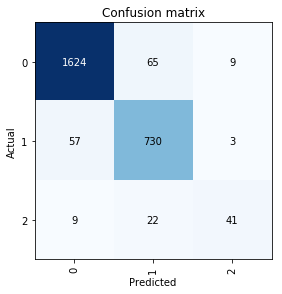

In [21]:
interp.plot_confusion_matrix()

In [22]:
# 0 - positive
# 1 - negative
# 2 - neutral